<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-포트폴리오-최적화-함수-생성" data-toc-modified-id="1.-포트폴리오-최적화-함수-생성-1">1. 포트폴리오 최적화 함수 생성</a></span></li><li><span><a href="#2.-우량주-포트폴리오-구현" data-toc-modified-id="2.-우량주-포트폴리오-구현-2">2. 우량주 포트폴리오 구현</a></span></li><li><span><a href="#3.-테마주-포트폴리오-구현" data-toc-modified-id="3.-테마주-포트폴리오-구현-3">3. 테마주 포트폴리오 구현</a></span></li></ul></div>

# 1. 포트폴리오 최적화 함수 생성

- get_data_yahoo 함수를 이용하여 5종목의 데이터를 수집하고, 효율적 투자선을 구함

    cf) 효율적 투자선: 현대 포트폴리오 이론의 핵심 개념. 투자자가 인내할 수 있는 리스크 수준에서 최상의 기대수익률을 제공하는 포트폴리오들의 집합
    
    
- 2만 개 포트폴리오 중에서 **측정된 위험 단위당 수익률(샤프 지수)이 제일 높은 행을 구하여 포트폴리오를 최적화함**


- 참고로 가장 안전한 포트폴리오는 Risk 값이 가장 작은 행임

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

# 시각화 한글 처리
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font',family=font_name)

In [2]:
class Portfolio:
    def __init__(self, data):
        self.data = data
    
    def read_yahoo(self, data):
        """get_data_yahoo 함수로 약 1년 간 데이터를 수집하여 데이터프레임으로 반환"""
        stocks = data.종목코드[:5].tolist()
        df = pd.DataFrame()
        
        for s in stocks:
            try:
                df[s] = pdr.get_data_yahoo(f'{s}.KS', '2020-01-01')['Close'].values
            except:
                df[s] = 0
        df.index = pdr.get_data_yahoo(f'{stocks[0]}.KS', '2020-01-01').index
        df.columns = [i for i in data.회사명[:5]]
        return stocks, df
        
    def create_port(self):
        """종목별 일간 수익률, 연간 수익률, 일간 리스크, 연간 리스크 계산"""
        stocks, df = self.read_yahoo(self.data)
        daily_ret = df.pct_change()
        annual_ret = daily_ret.mean() * 252     # 252는 1년 평균 개장일
        daily_cov = daily_ret.cov()
        annual_cov = daily_cov * 252
        
        rets = []
        risks = []
        weights = []
        sharpe = []

        """20000개의 포트폴리오 생성"""
        for _ in range(20000):
            weight = np.random.random(len(stocks))     # 5개의 랜덤 숫자 배열
            weight /= np.sum(weight)     # 5종목 비중의 합이 1이 되도록 조정

            # 해당 포트폴리오 전체 수익률 (종목별 비중 * 종목별 연간 수익률)
            ret = np.dot(weight, annual_ret)

            # 해당 포트폴리오 전체 리스크
            risk = np.sqrt(np.dot(weight.T, np.dot(annual_cov, weight)))

            rets.append(ret)
            risks.append(risk)
            weights.append(weight)
            sharpe.append(ret/risk)     # 샤프 지수 (수익률을 리스크로 나눈 값)

        portfolio = {'Returns': rets, 'Risk': risks, 'Sharpe': sharpe}
        for i, s in enumerate(stocks):
            portfolio[s] = [weight[i] for weight in weights]
        df2 = pd.DataFrame(portfolio)
        df2.columns = ['Returns','Risk','Sharpe'] + [i for i in data.회사명[:5]]
        return df2
    
    def result(self):
        """산점도 및 최적의 포트폴리오 출력"""
        df2 = self.create_port()
        max_sharpe = df2.loc[df2['Sharpe'] == df2['Sharpe'].max()]
        min_risk = df2.loc[df2['Risk'] == df2['Risk'].min()]

        df2.plot.scatter(x='Risk', y='Returns', c='Sharpe', cmap='viridis', edgecolors='k', figsize=(10,7), grid=True)
        plt.scatter(x=max_sharpe['Risk'], y=max_sharpe['Returns'], c='r', marker='*', s=300)
        plt.scatter(x=min_risk['Risk'], y=min_risk['Returns'], c='b', marker='*', s=200)
        plt.title('포트폴리오 최적화')
        plt.xlabel('Risk')
        plt.ylabel('Expected Returns')
        plt.show()
        return max_sharpe

# 2. 우량주 포트폴리오 구현

In [3]:
# 시가총액 상위 10% & 업종별 시가총액 1위 기업
data = pd.read_csv('./data/우량주저평가기업_시가총액.csv')
data.종목코드 = data.종목코드.map('{:06d}'.format)
data.head()

,회사명,종목코드,업종,업종2,업종PER,PER,PBR,시가총액(억)
0,현대자동차,005380,자동차용 엔진 및 자동차 제조업,자동차,58.96,58.54,0.92,523487.0
1,현대모비스,012330,자동차 신품 부품 제조업,자동차부품,46.67,20.22,0.94,315106.0
2,삼성물산,028260,기타 전문 도매업,복합기업,29.11,21.95,0.89,244822.0
3,포스코,005490,1차 철강 제조업,철강,41.60,24.82,0.48,236276.0
4,신한지주,055550,기타 금융업,은행,4.87,4.73,0.40,170220.0


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


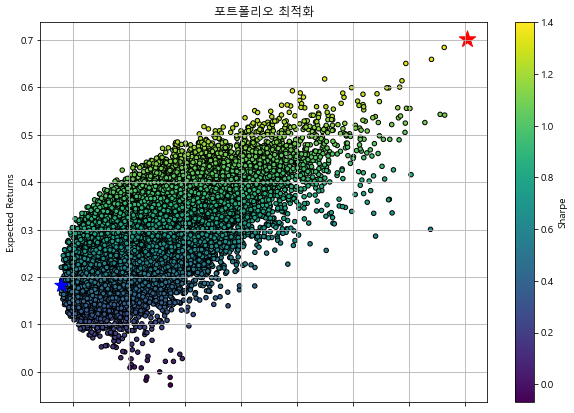

,Returns,Risk,Sharpe,현대자동차,현대모비스,삼성물산,포스코,신한지주
43,0.701936,0.500558,1.402307,0.839209,0.054098,0.038312,0.053554,0.014827


In [4]:
port = Portfolio(data)
port.result()

50%의 리스크에 70%의 수익률을 얻을 수 있음

종목별 비중은 현대자동차가 압도적으로 많고, 현대모비스, 포스코, 삼성물산, 신한지주 순서임

In [5]:
# 시가총액 상위 10% & 업종별 per가 가장 낮은 기업
data = pd.read_csv('./data/우량주저평가기업_PER.csv')
data.종목코드 = data.종목코드.map('{:06d}'.format)
data.head()

,회사명,종목코드,업종,업종2,업종PER,PER,PBR,시가총액(억)
0,현대자동차,005380,자동차용 엔진 및 자동차 제조업,자동차,58.96,58.54,0.92,523487.0
1,포스코,005490,1차 철강 제조업,철강,41.60,24.82,0.48,236276.0
2,LG,003550,기타 금융업,복합기업,29.11,15.55,0.94,189813.0
3,케이티,030200,전기 통신업,다각화된통신서비스,11.95,10.31,0.42,63189.0
4,LG유플러스,032640,전기 통신업,무선통신서비스,13.56,6.89,0.72,54576.0


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


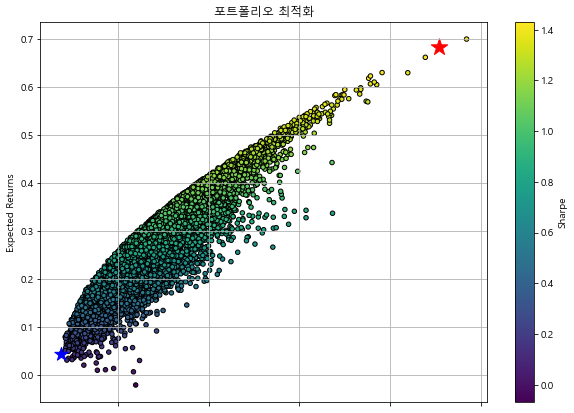

,Returns,Risk,Sharpe,현대자동차,포스코,LG,케이티,LG유플러스
11638,0.682816,0.477024,1.431408,0.818129,0.043477,0.068365,0.046554,0.023474


In [6]:
port = Portfolio(data)
port.result()

47%의 리스크에 68%의 수익률을 얻을 수 있음

종목별 비중은 역시 현대자동차가 압도적으로 많고, LG, 케이티, 포스코, LG유플러스 순서임

# 3. 테마주 포트폴리오 구현

- 우량주가 아닌 경우 get_data_yahoo 함수로 수집할 수 없는 데이터가 있으므로, 테마주는 BeautifulSoup 함수로 데이터를 수집함

In [37]:
from bs4 import BeautifulSoup
import requests
from datetime import datetime

In [42]:
class Portfolio:
    def __init__(self, data):
        self.data = data
    
    def read_yahoo(self, data):
        """BeautifulSoup 함수로 약 1년 간 데이터를 수집하여 데이터프레임으로 반환 (수정한 부분)"""
        stocks = data.종목코드[:5].tolist()
        df = pd.DataFrame()
        
        for s in stocks:
            test = pd.DataFrame()
            sise_url = f'https://finance.naver.com/item/sise_day.nhn?code={s}'
            for page in range(1, 30):
                page_url = '{}&page={}'.format(sise_url, page)
                test = test.append(pd.read_html(requests.get(page_url, headers={'User-agent': 'Mozilla/5.0'}).text)[0])
            test.index = test.날짜
            test = test.dropna()[['종가']]
            test.index = test.index.map(lambda x : datetime.strptime('-'.join(x.split('.')), "%Y-%m-%d"))
            test = test[test.index >= '2020-01-01'].sort_index()
            df = pd.concat([df, test], axis=1)
        df.columns = [i for i in data.회사명[:5]]
        return stocks, df
        
    def create_port(self):
        """종목별 일간 수익률, 연간 수익률, 일간 리스크, 연간 리스크 계산"""
        stocks, df = self.read_yahoo(self.data)
        daily_ret = df.pct_change()
        annual_ret = daily_ret.mean() * 252     # 252는 1년 평균 개장일
        daily_cov = daily_ret.cov()
        annual_cov = daily_cov * 252
        
        rets = []
        risks = []
        weights = []
        sharpe = []

        """20000개의 포트폴리오 생성"""
        for _ in range(20000):
            weight = np.random.random(len(stocks))     # 5개의 랜덤 숫자 배열
            weight /= np.sum(weight)     # 5종목 비중의 합이 1이 되도록 조정

            # 해당 포트폴리오 전체 수익률 (종목별 비중 * 종목별 연간 수익률)
            ret = np.dot(weight, annual_ret)

            # 해당 포트폴리오 전체 리스크
            risk = np.sqrt(np.dot(weight.T, np.dot(annual_cov, weight)))

            rets.append(ret)
            risks.append(risk)
            weights.append(weight)
            sharpe.append(ret/risk)     # 샤프 지수 (수익률을 리스크로 나눈 값)

        portfolio = {'Returns': rets, 'Risk': risks, 'Sharpe': sharpe}
        for i, s in enumerate(stocks):
            portfolio[s] = [weight[i] for weight in weights]
        df2 = pd.DataFrame(portfolio)
        df2.columns = ['Returns','Risk','Sharpe'] + [i for i in data.회사명[:5]]
        return df2
    
    def result(self):
        """산점도 및 최적의 포트폴리오 출력"""
        df2 = self.create_port()
        max_sharpe = df2.loc[df2['Sharpe'] == df2['Sharpe'].max()]
        min_risk = df2.loc[df2['Risk'] == df2['Risk'].min()]

        df2.plot.scatter(x='Risk', y='Returns', c='Sharpe', cmap='viridis', edgecolors='k', figsize=(10,7), grid=True)
        plt.scatter(x=max_sharpe['Risk'], y=max_sharpe['Returns'], c='r', marker='*', s=300)
        plt.scatter(x=min_risk['Risk'], y=min_risk['Returns'], c='b', marker='*', s=200)
        plt.title('포트폴리오 최적화')
        plt.xlabel('Risk')
        plt.ylabel('Expected Returns')
        plt.show()
        return max_sharpe

In [43]:
# 평균거래량이 높은 기업
data = pd.read_csv('./data/테마주저평가기업_평균거래량.csv')
data.종목코드 = data.종목코드.map('{:06d}'.format)
data.head()

,회사명,종목코드,업종,업종2,업종PER,PER,PBR,시가총액(억),등락률,평균거래량,거래대금(백만)
0,한화생명,088350,보험업,생명보험,12.49,11.41,0.16,26056.0,+4.53%,30371631.5,151330.0
1,크리스탈신소재,900250,기타 금융업,화학,69.00,4.86,0.40,1173.0,0.00%,8655658.0,23677.0
2,경남스틸,039240,1차 철강 제조업,철강,41.60,15.15,0.58,508.0,+4.06%,8135387.0,37428.0
3,NI스틸,008260,1차 철강 제조업,철강,41.60,11.35,0.74,867.0,+7.50%,7913834.5,53564.0
4,팬오션,028670,해상 운송업,해운사,116.29,19.11,0.85,25846.0,+5.99%,7913571.5,71613.0


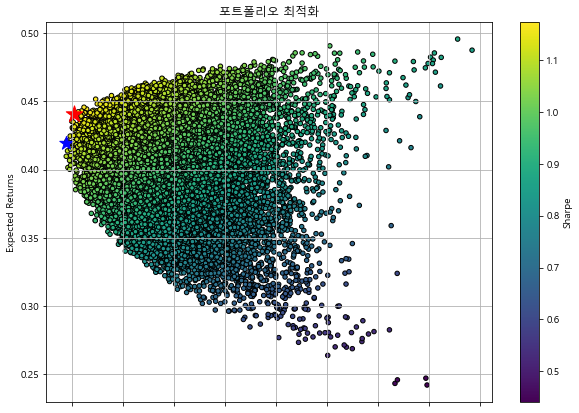

,Returns,Risk,Sharpe,한화생명,크리스탈신소재,경남스틸,NI스틸,팬오션
1601,0.440797,0.375804,1.172945,0.136109,0.002102,0.595087,0.23455,0.032152


In [44]:
port = Portfolio(data)
port.result()

37%의 리스크에 44%의 수익률을 얻을 수 있음

종목별 비중은 경남스틸, 한화생명, NI스틸, 팬오션, 크리스탈신소재 순서임

In [46]:
# 거래대금이 높은 기업
data = pd.read_csv('./data/테마주저평가기업_거래대금.csv')
data.종목코드 = data.종목코드.map('{:06d}'.format)
data.head()

,회사명,종목코드,업종,업종2,업종PER,PER,PBR,시가총액(억),등락률,평균거래량,거래대금(백만)
0,한화생명,088350,보험업,생명보험,12.49,11.41,0.16,26056.0,+4.53%,30371631.5,151330.0
1,팬오션,028670,해상 운송업,해운사,116.29,19.11,0.85,25846.0,+5.99%,7913571.5,71613.0
2,NI스틸,008260,1차 철강 제조업,철강,41.60,11.35,0.74,867.0,+7.50%,7913834.5,53564.0
3,S&K폴리텍,091340,전자부품 제조업,전자장비와기기,65.66,50.56,0.62,633.0,+4.89%,3160019.0,37881.0
4,경남스틸,039240,1차 철강 제조업,철강,41.60,15.15,0.58,508.0,+4.06%,8135387.0,37428.0


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


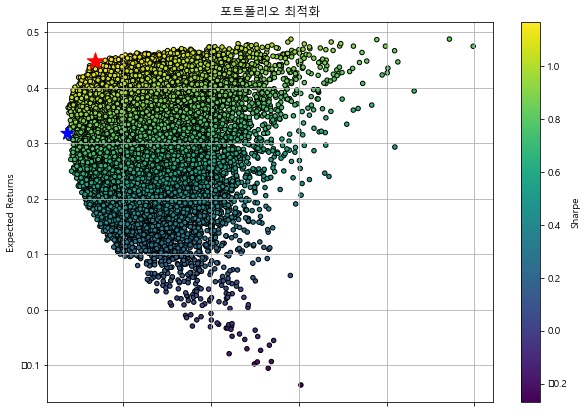

,Returns,Risk,Sharpe,한화생명,팬오션,NI스틸,S&K폴리텍,경남스틸
6057,0.447589,0.383849,1.166053,0.228201,0.021745,0.192434,0.002691,0.554929


In [47]:
port = Portfolio(data)
port.result()

38%의 리스크에 44%의 수익률을 얻을 수 있음

종목별 비중은 경남스틸, 한화생명, 팬오션, NI스틸, S&K폴리텍 순서임

In [48]:
# 거래량 & 거래대금이 높은 기업
data = pd.read_csv('./data/테마주저평가기업_거래량&거래대금.csv')
data.종목코드 = data.종목코드.map('{:06d}'.format)
data.head()

,회사명,종목코드,업종,업종2,업종PER,PER,PBR,시가총액(억),등락률,평균거래량,거래대금(백만)
0,한화생명,088350,보험업,생명보험,12.49,11.41,0.16,26056.0,+4.53%,30371631.5,151330.0
1,NI스틸,008260,1차 철강 제조업,철강,41.60,11.35,0.74,867.0,+7.50%,7913834.5,53564.0
2,팬오션,028670,해상 운송업,해운사,116.29,19.11,0.85,25846.0,+5.99%,7913571.5,71613.0
3,경남스틸,039240,1차 철강 제조업,철강,41.60,15.15,0.58,508.0,+4.06%,8135387.0,37428.0
4,크리스탈신소재,900250,기타 금융업,화학,69.00,4.86,0.40,1173.0,0.00%,8655658.0,23677.0


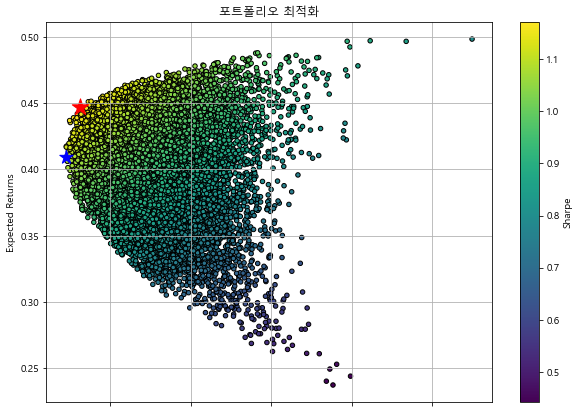

,Returns,Risk,Sharpe,한화생명,NI스틸,팬오션,경남스틸,크리스탈신소재
8528,0.446602,0.380969,1.17228,0.176117,0.290744,0.024515,0.503456,0.005168


In [49]:
port = Portfolio(data)
port.result()

38%의 리스크에 44%의 수익률을 얻을 수 있음

종목별 비중은 경남스틸, NI스틸, 한화생명, 팬오션, 크리스탈신소재 순서임

- 테마주는 꾸준히 상승하는 추세라기보다 단기간에 주목받은 종목들이 대부분임


- 따라서 효율적 투자선이 우량주와는 완전히 다른 형태를 보임


- **1년치 데이터를 기반으로 포트폴리오를 구현하는 방법은 공격투자형(단기투자)에게 다소 부적절하므로, 다른 방법을 생각할 필요가 있음**